In [1]:
import matplotlib.pyplot as plt
import math
import random

In [2]:
class env:
    def __init__(self,obs_x,obs_y,xmin,xmax,ymin,ymax):
        self.obst_x = obs_x
        self.obst_y = obs_y
        self.xlim = (xmin,xmax)
        self.ylim = (ymin,ymax)
        
    def obs_add(self,ox,oy):
        self.obst_x += ox
        self.obst_y += oy

    def inobstacle(self,x1,y1,x2,y2): #check if edge lies inside obstacle
        c=1 #assume no collision
        obs_num = len(self.obst_x)/4 
        for i in range(1,int(obs_num)+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            for j in range(0,101):
                u=j/100.0
                x=x1*u+x2*(1-u)
                y=y1*u+y2*(1-u)
                if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                    c=0
                    break
            if c==0:
                break
        return c

    def isfree(self): #check if new node lies inside obstacle
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        obs_num = len(self.obst_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,int(obs_num)+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                G.remove_node(n)
                return 0
                break
        return 1
                
    def ingoal(self):
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        if (x>=xgmin) and (x<=xgmax) and (y>=ygmin) and (y<=ygmax):
            return 1
        else:
            return 0

#check for a specific node
    def isfree_xy(self,x,y): 
        obs_num = len(self.obst_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,obs_num+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                return 0
            break

#Sensing
#Check for obstacles given the robot's current position and the sensor 
#Only hidden obstacles are checked, others are known a-priori

#     def sense (self,x,y,r):
#         obs_num = len(hvx)/4 #four vertices for each rectangular obstacle
#         for i in range(1,obs_num+1):
#             xomin=hvx[4*(i-1)]-r
#             xomax=hvx[4*(i-1)+2]+r
#             yomin=hvy[4*(i-1)]-r
#             yomax=hvy[4*(i-1)+1]+r
#             if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
# #if the robot is within the sensing range of the obstacle, add it to visibile list
#                 hx_i= [hvx[4*(i-1)],hvx[4*(i-1)],hvx[4*(i-1)+2],hvx[4*(i-1)+2]]
#                 hy_i= [hvy[4*(i-1)],hvy[4*(i-1)+1],hvy[4*(i-1)+1],hvy[4*(i-1)]]
#                 self.obs_add(hx_i,hy_i)
# #add point where new obstacle detected
#                 return 1

In [24]:
class RRT:
    def __init__(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)

    #get metric value (current metric is euclidean distance)
    def metric(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        x1=float(x1)
        y1=float(y1)
        x2=float(x2)
        y2=float(y2)
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric

    #expand a random point
    #calls subroutines to find nearest node and connect it
    def expand (self):
        #add random node
        x = random.uniform (E.xlim[0], E.xlim[1])
        y = random.uniform (E.ylim[0], E.ylim[1])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y)
        if E.isfree()!=0:
            #find nearest node
            nnear = self.near(n)
            #find new node based on step size
            self.step(nnear,n)
            #connect the random node with its nearest node
            self.connect(nnear,n)

    def bias (self):
        #add random node
        n= self.number_of_nodes() #new node
        self.add_node(n,xg,yg) #test goal region
        #find nearest node
        nnear = self.near(n)
        #find new node based on step size
        self.step(nnear,n)
        #connect the random node with its nearest node
        self.connect(nnear,n)

    #nearest node
    def near(self,n):
        #find a near node
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if self.metric(i,n) < dmin:
                dmin=self.metric(i,n)
                nnear = i
        return nnear

#step size
    def step(self,nnear,nrand):
        d = self.metric(nnear,nrand)
        if d>dmax:
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (xrand,yrand)= (self.x[nrand],self.y[nrand]) 
            (px,py)=(xrand-xnear,yrand-ynear)
            theta = math.atan2(py,px)
            (x,y)=(xnear+dmax*math.cos(theta),ynear+dmax*math.sin(theta))
            self.remove_node(nrand)
            self.add_node(nrand,x,y) #this is a new node between rand and near

#connect two nodes (local planner)
    def connect(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        n= G.number_of_nodes()-1
        #subdivide path into 100 small segments and ensure each segment is collision free
        if E.inobstacle(x1,y1,x2,y2)==0:
            self.remove_node(n2)
        else:
            self.add_edge(n1,n2)


#add node
    def add_node(self,n,x,y):
        self.x.insert(n, x)
        self.y.insert(n, y)

#remove node
    def remove_node(self,n):
        self.x.pop(n)
        self.y.pop(n)

#add edge
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

#remove node
    def remove_edge(self,n):
        self.parent.pop(n)
#clear
    def clear(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)
        
#number of nodes
    def number_of_nodes(self):
        return len(self.x)

#path to goal
    def path_to_goal(self):
        #find goal state
        for i in range (0,G.number_of_nodes()):
            (x,y)= (self.x[i],self.y[i])
            if (x>=xgmin) and (x<=xgmax) and (y>=ygmin) and (y<=ygmax):
                self.goalstate = i
                break
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
        #add start state
        self.path.append(0)

    def prun(self):
        #initial query nodes in the path
        #we already know 0-1 is collision free
        #start by checking 0-2
        s=0
        e=2
        self.tpath=[]
        self.tpath.append(self.path[s])
        for e in range(len(self.path)-1):
            (x1,y1)=(self.x[self.path[s]],self.y[self.path[s]])
            (x2,y2)=(self.x[self.path[e]],self.y[self.path[e]])
            if E.inobstacle(x1,y1,x2,y2)==0: #CC is detected
                c=0
                self.tpath.append(self.path[e-1])
                s=e-1
        self.tpath.append(self.path[-1])
        
#     def waypoints(self):
#     #subdivide path into small waypoints
#     #in future can be replaced with B-spline planning
#         self.wayx=[]
#         self.wayy=[]
#         self.newstart=[]
#         for i in range (0,len(self.tpath)-1):
#             (x1,y1)=(self.x[self.tpath[i]],self.y[self.tpath[i]])
#             (x2,y2)=(self.x[self.tpath[i+1]],self.y[self.tpath[i+1]])
#             for j in range (0,101):
#                 dt=j/100.0
#                 x=x1*(dt)+x2*(1-dt)
#                 y=y1*(dt)+y2*(1-dt)
#                 self.wayx.append(x)
#                 self.wayy.append(y)
#                 #measurement update
#                 E.sense(x,y,20)
#                 #collision after update
#                 if E.isfree_xy(x,y)==0:
#                     #point before collision is used for generating new plan
#                     self.newstart.append(i*101+j-10)
#                     break

#     def sense(self):
#         while(len(self.newstart)!=0):
#             #first observation state\
#             cn=self.newstart[0]
#             cx=self.wayx[cn]
#             cy=self.wayy[cn]
#             self.clear((cx,cy))
#             #balance between extending and biasing
#             for i in range(0,nmax):
#                 if i%10!=0: self.expand()
#                 else: self.bias()
#             #check if sample is in goal, if so STOP!
#                 if E.ingoal()==1:
#                     break
#             plt.text(45, 103, 'Loops: %d' %(i+1))

#             cn=self.newstart[0]
#             cx=self.wayx[cn]
#             cy=self.wayy[cn]
#             plt.plot(cx,cy,'yo',markersize=75,alpha=0.3)

#             #find path in RRT
#             self.path_to_goal()
#             self.prun()
#             #display initial plan under limited sensing
#             draw()
#             #execute
#             self.waypoints()

    #draw tree
    def showtree(self,k):
        node_num = 0
        for i in range (0,self.number_of_nodes()):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)
            n = len(self.path)-1
            if (node_num <= n-2):
                n1 = self.path[n-node_num]
                n2 = self.path[n-(node_num+1)]
                if (self.x[i]==self.x[n1] and self.y[i]==self.y[n1]):
#                     print ("yay")
                    plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],'ro-',lw=1,markersize=3)
                    node_num+=1
            plt.title('Step: %d' %(i+1))
            name = 'data/snap%s.png'%str(i)
            plt.savefig(name, dpi = 200)

    #draw path 
    def showpath(self,k):
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
#             plt.title('Loops: %d' %(i+1))
#             name = 'data/snap%s.png'%str(i)
#             plt.savefig(name, dpi = 200)

In [27]:
def draw ():
    #draw boundary
    plt.plot([0,0,100,100,0],[0,100,100,0,0],'k',lw=0.5)

    #goal region
#     plt.plot([xgmin,xgmin,xgmax,xgmax,xgmin],[ygmin,ygmax,ygmax,ygmin,ygmin],'g',lw=2)
    plt.plot(xg,yg,'g*',markersize=10)

    num = len(E.obst_x)/4
    for i in range(1,int(num)+1):
        plt.plot([E.obst_x[4*(i-1)],E.obst_x[4*(i-1)+1],E.obst_x[4*(i-1)+2],
        E.obst_x[4*(i-1)+3],E.obst_x[4*(i-1)]],[E.obst_y[4*(i-1)],E.obst_y[4*(i-1)+1],
        E.obst_y[4*(i-1)+2],E.obst_y[4*(i-1)+3],E.obst_y[4*(i-1)]],'k',lw=2)
    G.showtree('0.15')
 
    #draw path
    G.showpath('ro-')
#     G.showtpath('g*-')
    
    #draw obstacles


    #draw  hidden obstacles (if they exist)
#     obs_num = len(hvx)/4
#     for i in range(1,int(obs_num)+1):
#         plt.plot([hvx[4*(i-1)],hvx[4*(i-1)+1],hvx[4*(i-1)+2],hvx[4*(i-1)+3],hvx[4*(i-1)]],[hvy[4*(i-1)],hvy[4*(i-1)+1],hvy[4*(i-1)+2],hvy[4*(i-1)+3],hvy[4*(i-1)]],'k--',lw=2)	

    plt.show()

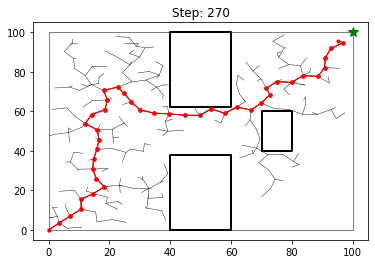

In [28]:
nmax = 5000

#goal region
xg=100
yg=100
epsilon=5
xgmin=xg-epsilon
xgmax=xg+epsilon
ygmin=yg-epsilon
ygmax=yg+epsilon

#extend step size
dmax = 5
#start the root of the tree
nstart =(0,0) 

#specify vertices for rectangular obstacles (each object has four vertices)
#obstacles known a priori
vx= [40,40,60,60,70,70,80,80,40,40,60,60]
vy= [62,100,100,62,40,60,60,40, 0,38,38, 0]

#create an RRT tree with a start node
G=RRT(nstart)

#environment instance
E=env(vx,vy,0,100,0,100)

def main():
#     draw()
    for i in range(0,nmax):
#         if i%10!=0:
        G.expand()
        
        if E.ingoal()==1:
            break
    G.path_to_goal()
#     G.prun()
    
    draw()

    #display initial plan under limited sensing
#     G.path_to_goal()
#     G.prun()

    
# run main when RRT is called
if __name__ == '__main__':
    main()

In [29]:
G.parent

[0,
 0,
 1,
 2,
 3,
 3,
 5,
 4,
 6,
 8,
 9,
 8,
 10,
 12,
 1,
 13,
 11,
 16,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 17,
 22,
 22,
 25,
 12,
 29,
 31,
 32,
 32,
 33,
 30,
 34,
 31,
 36,
 38,
 37,
 14,
 29,
 19,
 13,
 41,
 28,
 41,
 47,
 14,
 43,
 16,
 43,
 40,
 21,
 12,
 35,
 57,
 24,
 20,
 51,
 6,
 51,
 5,
 54,
 33,
 65,
 67,
 47,
 48,
 43,
 67,
 19,
 62,
 66,
 68,
 9,
 76,
 72,
 36,
 73,
 63,
 53,
 61,
 30,
 78,
 86,
 27,
 22,
 87,
 75,
 74,
 35,
 52,
 79,
 81,
 46,
 90,
 24,
 43,
 66,
 98,
 55,
 98,
 102,
 104,
 84,
 2,
 54,
 105,
 30,
 64,
 105,
 113,
 69,
 70,
 83,
 114,
 12,
 90,
 41,
 87,
 97,
 83,
 118,
 122,
 125,
 74,
 97,
 127,
 130,
 130,
 94,
 71,
 120,
 118,
 84,
 25,
 47,
 63,
 89,
 79,
 136,
 7,
 127,
 119,
 86,
 40,
 137,
 126,
 52,
 6,
 110,
 76,
 135,
 55,
 149,
 119,
 129,
 12,
 106,
 131,
 155,
 93,
 21,
 156,
 141,
 46,
 153,
 161,
 129,
 170,
 136,
 29,
 173,
 163,
 176,
 138,
 176,
 173,
 161,
 156,
 150,
 103,
 131,
 179,
 94,
 103,
 153,
 100,
 85,
 186,
 81,

In [147]:
G.path

[415,
 335,
 182,
 152,
 125,
 95,
 91,
 90,
 88,
 78,
 77,
 73,
 70,
 66,
 64,
 63,
 62,
 61,
 59,
 56,
 47,
 25,
 23,
 17,
 14,
 13,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]